In [1]:
import os
import sys

import numpy as np
import pandas as pd

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_curve, roc_auc_score, auc, precision_recall_curve

from scipy.stats import randint

import seaborn as sns
import matplotlib.pyplot as plt

# Constants

In [2]:
RANDOM_STATE = 42 # to get the same random values with different .ipynb sessions
N_ITER = 5 # number of iterations while searching hyperparameters of the model
N_CV = 5 # number of folds in crossvalidation

In [3]:
PROJECT_PATH = os.getcwd() # get current working directory
PROJECT_PATH = os.path.join(PROJECT_PATH, "..") # go to higher folder 

DATA_PATH = os.path.join(PROJECT_PATH, "data") # define path to the data
MODELS_PATH = os.path.join(PROJECT_PATH, "models") # define path to the models

In [4]:
sys.path.append(PROJECT_PATH) # add higher direcotory to load self-written metrics
from tools.metrics import * 

In [5]:
if not os.path.isdir(MODELS_PATH): # create a folder for models, if it doesn't exist 
    os.makedirs(MODELS_PATH)

# Read Data

In [6]:
df = pd.read_csv(os.path.join(DATA_PATH, "train.csv"))

In [7]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [8]:
print("Target distribution:")
df.Survived.value_counts(normalize=True)

Target distribution:


0    0.616162
1    0.383838
Name: Survived, dtype: float64

# EDA

In [9]:
# define list of columns to train model
COLS_TO_TRAIN = []

## Pclass

In [10]:
# compute distribution per target 
temp = df.groupby(["Survived", "Pclass"]).PassengerId.count().reset_index(name="n")
temp = pd.merge(temp, temp.groupby("Survived").n.sum().reset_index(name="total"), on="Survived", how="left")
temp["%"] = temp["n"] * 100 / temp["total"]

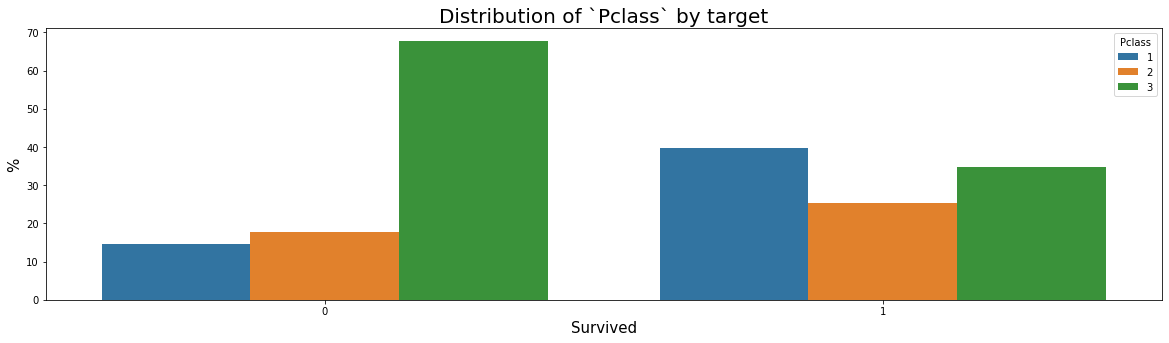

In [11]:
_ = plt.figure(figsize=(20, 5))
_ = sns.barplot(x="Survived", y="%", hue="Pclass", data=temp)
_ = plt.title("Distribution of `Pclass` by target", fontsize=20)
_ = plt.xlabel("Survived", fontsize=15)
_ = plt.ylabel("%", fontsize=15)

In [12]:
# this column is categorical, so it should be transformed using one-hot encoding before further usage
# there are only 3 unique values of the feature. 
# If we know e.g. that one didn't have a 1st and 2nd class ticket, it means, that one was from the 3d class.
# So we can remove one encoded column.
# more details about one hot encoding: https://en.wikipedia.org/wiki/One-hot

class_uniques = df["Pclass"].unique()[:-1]
class_cols = ["Pclass_" + str(c) for c in class_uniques]
COLS_TO_TRAIN += class_cols

In [13]:
df_dummy = pd.get_dummies(df["Pclass"], prefix="Pclass")
df = pd.concat((df, df_dummy[class_cols]), axis=1)

## Sex

In [14]:
temp = df.groupby(["Survived", "Sex"]).PassengerId.count().reset_index(name="n")
temp = pd.merge(temp, temp.groupby("Survived").n.sum().reset_index(name="total"), on="Survived", how="left")
temp["%"] = round(temp["n"] * 100 / temp["total"], 2)

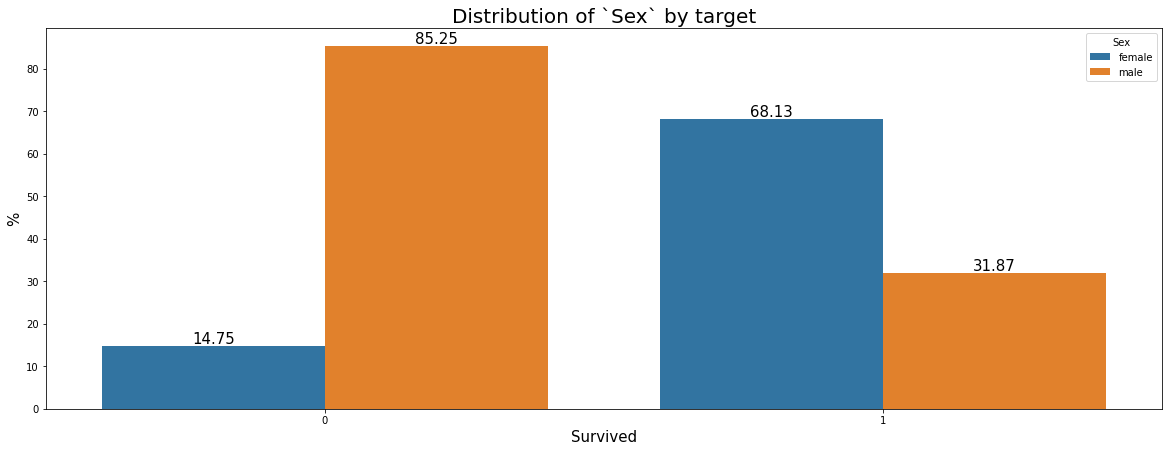

In [15]:
_ = plt.figure(figsize=(20, 7))
f = sns.barplot(x="Survived", y="%", hue="Sex", data=temp)

for container in f.containers:
    f.bar_label(container, fontsize=15)

_ = plt.title("Distribution of `Sex` by target", fontsize=20)
_ = plt.xlabel("Survived", fontsize=15)
_ = plt.ylabel("%", fontsize=15)

In [16]:
df["IfMale"] = (df["Sex"] == "male").astype(int)
COLS_TO_TRAIN += ["IfMale"]

## Fare

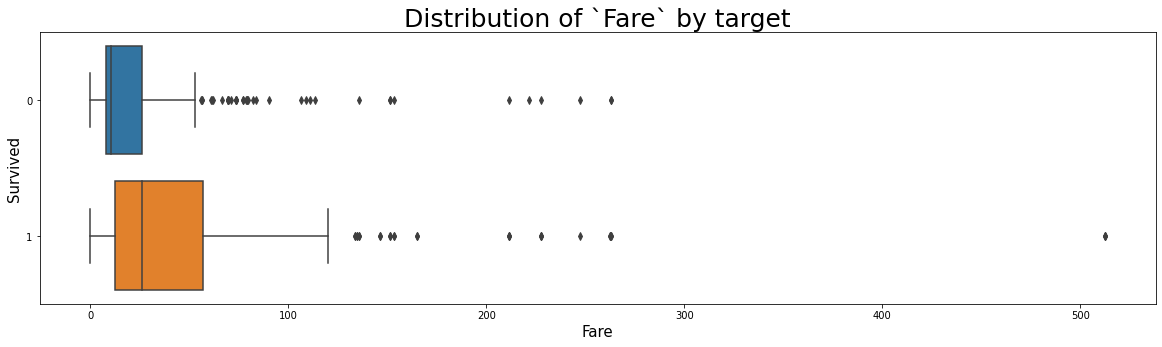

In [17]:
# Information about boxplots: https://en.wikipedia.org/wiki/Box_plot
_ = plt.figure(figsize=(20, 5))
_ = sns.boxplot(y="Survived", x="Fare", data=df, orient="h")
_ = plt.title("Distribution of `Fare` by target", fontsize=25)
_ = plt.xlabel("Fare", fontsize=15)
_ = plt.ylabel("Survived", fontsize=15)

In [18]:
COLS_TO_TRAIN += ["Fare"] 

## Age

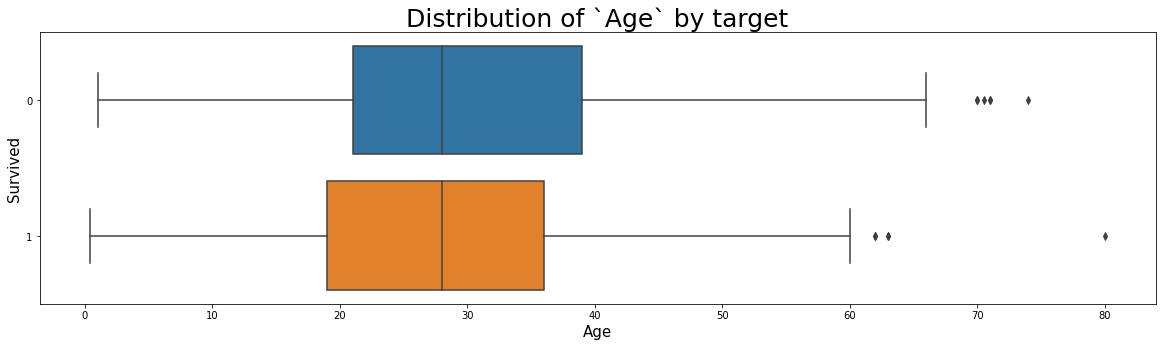

In [19]:
_ = plt.figure(figsize=(20, 5))
_ = sns.boxplot(y="Survived", x="Age", data=df, orient="h")
_ = plt.title("Distribution of `Age` by target", fontsize=25)
_ = plt.xlabel("Age", fontsize=15)
_ = plt.ylabel("Survived", fontsize=15)

In [20]:
COLS_TO_TRAIN += ["Age"]

In [21]:
df.Age.fillna(df.Age.median(), inplace=True)

In [22]:
df[COLS_TO_TRAIN].isna().any().any()

False

In [23]:
df = df[COLS_TO_TRAIN + ["Survived"]]

# Generate train, test, inference

Data is split into 3 parts: 

    - train - 80% of observations
    
    - test - 14% of observations
    
    - inference - 6% of observations
    
Train will be used to train a model.

Test - to evaluate its performance.

Inference - to compare how model performs on 'recently' received datam

In [24]:
# split into train and test, where test will contain both test, inference
df_train, df_test = train_test_split(
    df, train_size=0.8, random_state=RANDOM_STATE, shuffle=True
)
# separate test & inference
df_test, df_inf = train_test_split(
    df_test, train_size=0.7, random_state=RANDOM_STATE, shuffle=True
)

df_train.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)
df_inf.reset_index(drop=True, inplace=True)

In [25]:
print("#observations:")
print("Train: ", df_train.shape[0])
print("Test: ", df_test.shape[0])
print("`Recently` come data (inference): ", df_inf.shape[0])

assert df_train.shape[0] + df_test.shape[0] + df_inf.shape[0] == df.shape[0]
del df

#observations:
Train:  712
Test:  125
`Recently` come data (inference):  54


In [26]:
# transform train pandas data frame, target to numpy array
X_train = df_train[COLS_TO_TRAIN].to_numpy()
y_train = df_train.Survived.to_numpy()

In [27]:
# save train data frame
df_train.to_csv(os.path.join(DATA_PATH, "train_exprmnt.csv"))

In [28]:
# transform test pandas data frame, target to numpy array
X_test = df_test[COLS_TO_TRAIN].to_numpy()
y_test = df_test.Survived.to_numpy()

In [29]:
# transform inference pandas data frame, target to numpy array
X_inf = df_inf[COLS_TO_TRAIN].to_numpy()
y_inf = df_inf.Survived.to_numpy()

In [30]:
print("Check shapes of inputs to the model (train stage): ")
print("Features: ", X_train.shape)
print("Target: ", y_train.shape)

Check shapes of inputs to the model (train stage): 
Features:  (712, 5)
Target:  (712,)


In [31]:
print("Check shapes of inputs to the model (test stage): ")
print("Features: ", X_test.shape)
print("Target: ", y_test.shape)

Check shapes of inputs to the model (test stage): 
Features:  (125, 5)
Target:  (125,)


In [32]:
print("Check shapes of inputs to the model (inference stage): ")
print("Features: ", X_inf.shape)
print("Target: ", y_inf.shape)

Check shapes of inputs to the model (inference stage): 
Features:  (54, 5)
Target:  (54,)


# Develop a model

In [33]:
# More about 
# - RandomForest: 
#    -> https://en.wikipedia.org/wiki/Random_forest
#    -> https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
# - RandomizedSearchCV:  
#    -> https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html
# initialize Random Forest Classifier
clf = RandomForestClassifier(
    random_state=RANDOM_STATE, 
    class_weight="balanced",
)

# initialize parameters of diftributions to run randomized search
distributions = dict(
    criterion=["gini", "entropy", "log_loss"],
    max_depth=randint(2, 3),
    n_estimators=randint(2, 10),
    min_samples_split=randint(2, 10),
    max_features=randint(2, 5)
)

# initialize random search object
clf = RandomizedSearchCV(clf, distributions, random_state=RANDOM_STATE, n_iter=N_ITER, cv=N_CV)

# search for the optimal model's hyperparameters
search = clf.fit(X_train, y_train)

In [34]:
# optimal model's hyperparameters
search.best_params_

{'criterion': 'gini',
 'max_depth': 2,
 'max_features': 4,
 'min_samples_split': 7,
 'n_estimators': 6}

In [35]:
assert search.best_score_ == search.cv_results_["mean_test_score"][search.best_index_]

In [36]:
# best model's merformance on CV
print("Mean CV score: ", search.cv_results_["mean_test_score"][search.best_index_])
print("STD CV score: ", search.cv_results_["std_test_score"][search.best_index_])

Mean CV score:  0.7963065103910175
STD CV score:  0.027729921935874324


In [37]:
# initialize Random Forest with the optimal hyperparameters
clf = RandomForestClassifier(
    random_state=RANDOM_STATE, 
    class_weight="balanced", 
    **search.best_params_
)
# train it
clf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=2, max_features=4,
                       min_samples_split=7, n_estimators=6, random_state=42)

In [38]:
# make predictions for test
df_test["y_prob"] = clf.predict_proba(X_test)[:, 1]
df_test["y_pred"] = (df_test["y_prob"] >= 0.5).astype(int)
df_test["DataPart"] ="Benchmark"

In [39]:
# make predictions for inference
df_inf["y_prob"] = clf.predict_proba(X_inf)[:, 1]
df_inf["y_pred"] = (df_inf["y_prob"] >= 0.5).astype(int)
df_inf["DataPart"] ="Inference"

# concatenate test & inference andd save it as a separate file
df_test_inf = pd.concat((df_inf, df_test), axis=0)
df_test_inf.reset_index(drop=True, inplace=True)
df_test_inf.to_csv(os.path.join(DATA_PATH, "test_exprmnt.csv"))

In [40]:
# generate random subsample from test & inference dataset just to test a streamlit feature
np.random.seed(RANDOM_STATE)
indx = np.random.choice(df_test_inf.index, size=50, replace=False)
df_test_inf = df_test_inf.iloc[indx, :]
df_test_inf.to_csv(os.path.join(DATA_PATH, "test_exprmnt_2.csv"))

# Metrics

**Accuracy** is a metric that generally describes how the model performs across all classes. More about accuracy metric: [link](https://en.wikipedia.org/wiki/Accuracy_and_precision)

$$Accuracy = \frac{correct\ classifications}{all\ classifications}$$



The below definitions are needed to describe the next metrics.

![alt text](confusion_matrix.png "Title")


**Precision** attempts to answer the following question: What proportion of positive identifications was actually correct?
$$Precision = \frac{tp}{tp + fp}$$

**Recall** attempts to answer the following question: What proportion of actual positives was identified correctly?

$$Recall = \frac{tp}{tp + fn}$$

More about precision & recall metrics: [link](https://en.wikipedia.org/wiki/Precision_and_recall)

**Receiver operating characteristic curve (ROC curve)**, is a graphical plot that illustrates the diagnostic ability of a binary classifier system as its discrimination threshold is varied. Additional details can be found: [link](https://en.wikipedia.org/wiki/Receiver_operating_characteristic)

**ROC AUC** - the area under the ROC curve is equal to the probability that a classifier will rank a randomly chosen positive instance higher than a randomly chosen negative one (assuming 'positive' ranks higher than 'negative'). Details by [link](https://en.wikipedia.org/wiki/Receiver_operating_characteristic)

The **precision-recall curve** shows the tradeoff between precision and recall for different threshold. More information by [link](https://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html#:~:text=The%20precision%2Drecall%20curve%20shows,a%20low%20false%20negative%20rate.)

**Precision-Recall AUC** - area under the precision-recall curve. More details by [link](https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/)

## Test

### Accuracy, Precision, Recall, ROC AUC, Precision Recall AUC

In [42]:
# compute metrics on test data
accuracy_value = accuracy_score(df_test["Survived"] , df_test["y_pred"])
precision_value = precision_score(df_test["Survived"] , df_test["y_pred"])
recall_value = recall_score(df_test["Survived"] , df_test["y_pred"])
roc_auc_value = roc_auc_score(df_test["Survived"] , df_test["y_pred"])


precision_list, recall_list, _ = precision_recall_curve(df_test["Survived"] , df_test["y_prob"])
prec_recall_auc = auc(recall_list, precision_list)

# combie them into one data frame for further manipulations
df_metrics_benchmark = pd.DataFrame.from_dict(
    {
        "Accuracy": round(accuracy_value, 3),
        "Precision": round(precision_value, 3),
        "Recall": round(recall_value, 3),
        "PR AUC": round(prec_recall_auc, 3),
        "ROC AUC": round(roc_auc_value, 3)
    }, 
    orient="index", 
    columns=["Benchmark"]
)

In [43]:
df_metrics_benchmark

,Benchmark
Accuracy,0.784
Precision,0.816
Recall,0.690
PR AUC,0.877
ROC AUC,0.778


### Precision Recall Curve, AUC

In [44]:
# put precision, recall values per threshold to a data frame for further plotting them as Precision Recall Curve
df_pr_rc_benchmark = pd.DataFrame.from_dict(
    {
        "Precision": precision_list,
        "Recall": recall_list
    }
)
df_pr_rc_benchmark["Data"] = "Benchmark"

In [45]:
df_pr_rc_benchmark

,Precision,Recall,Data
0,0.464000,1.000000,Benchmark
1,0.625000,0.948276,Benchmark
2,0.647059,0.948276,Benchmark
3,0.675325,0.896552,Benchmark
4,0.803922,0.706897,Benchmark
5,0.800000,0.689655,Benchmark
6,0.816327,0.689655,Benchmark
7,0.833333,0.689655,Benchmark
8,0.961538,0.431034,Benchmark
9,1.000000,0.275862,Benchmark


### ROC Curve, ROC AUC

In [46]:
# compute false positive rate, true positive rate and save them as a separate data frame to plot ROC curve in the future
fpr_list, tpr_list, _ = roc_curve(df_test["Survived"] , df_test["y_prob"])

df_fp_tp_benchmark = pd.DataFrame.from_dict(
    {
        "False Positive Ratio": fpr_list,
        "True Positive Ratio": tpr_list
    }
)
df_fp_tp_benchmark["Data"] = "Benchmark"
df_fp_tp_benchmark

,False Positive Ratio,True Positive Ratio,Data
0,0.000000,0.000000,Benchmark
1,0.000000,0.275862,Benchmark
2,0.014925,0.431034,Benchmark
3,0.119403,0.689655,Benchmark
4,0.149254,0.689655,Benchmark
5,0.149254,0.706897,Benchmark
6,0.373134,0.896552,Benchmark
7,0.447761,0.948276,Benchmark
8,0.492537,0.948276,Benchmark
9,1.000000,1.000000,Benchmark


## Inference

Compute metrics on the inference data

### Accuracy, Precision, Recall, Precision Recall AUC, ROC AUC

In [47]:
accuracy_value = accuracy_score(df_inf["Survived"] , df_inf["y_pred"])
precision_value = precision_score(df_inf["Survived"] , df_inf["y_pred"])
recall_value = recall_score(df_inf["Survived"] , df_inf["y_pred"])
roc_auc_value = roc_auc_score(df_inf["Survived"] , df_inf["y_prob"])

precision_list, recall_list, _ = precision_recall_curve(df_inf["Survived"] , df_inf["y_prob"])
prec_recall_auc = auc(recall_list, precision_list)

# create a separate data fframe for metrics based on inference
df_metrics_new_pred = pd.DataFrame.from_dict(
    {
        "Accuracy": round(accuracy_value, 3),
        "Precision": round(precision_value, 3),
        "Recall": round(recall_value, 3),
        "PR AUC": round(prec_recall_auc, 3),
        "ROC AUC": round(roc_auc_value, 3)
    }, 
    orient="index", 
    columns=["Inference"]
)

In [48]:
# join metrics on test and inference
df_metrics = pd.concat((df_metrics_benchmark, df_metrics_new_pred), axis=1)
del df_metrics_benchmark, df_metrics_new_pred

In [49]:
# compute percentage of change between benchmark and inference values
df_metrics["% change"] = round(
    (df_metrics["Inference"] - df_metrics["Benchmark"]) * 100 / df_metrics["Benchmark"], 
    3
)

In [50]:
df_metrics

,Benchmark,Inference,% change
Accuracy,0.784,0.778,-0.765
Precision,0.816,0.591,-27.574
Recall,0.690,0.812,17.681
PR AUC,0.877,0.850,-3.079
ROC AUC,0.778,0.907,16.581


In [51]:
# save metrics values on test, inference as .csv file
df_metrics = df_metrics.reset_index().rename(columns={"index": "Metrics"})
df_metrics.to_csv(os.path.join(DATA_PATH, 'metrics.csv'), index=False)

### Precision Recall Curve, AUC

In [52]:
# create a separate data frame for precision, recall lists to plot them further as Precision Recall Curve
df_pr_rc_new_pred = pd.DataFrame.from_dict(
    {
        "Precision": precision_list,
        "Recall": recall_list
    }
)
df_pr_rc_new_pred["Data"] = "Inference"

In [53]:
# join precision-recsll data frame for test and inference 
df_pr_rc = pd.concat((df_pr_rc_benchmark, df_pr_rc_new_pred), axis=0)

In [54]:
df_pr_rc.to_csv(os.path.join(DATA_PATH, 'precision_recall.csv'), index=False)

### ROC Curve, ROC AUC

In [55]:
# create a separate data frame for false positive and true positive rates to plot them further as ROC curve
fpr_list, tpr_list, _ = roc_curve(df_inf["Survived"] , df_inf["y_prob"])

df_fp_tp_new_pred = pd.DataFrame.from_dict(
    {
        "False Positive Ratio": fpr_list,
        "True Positive Ratio": tpr_list
    }
)
df_fp_tp_new_pred["Data"] = "Inference"
df_fp_tp_new_pred

,False Positive Ratio,True Positive Ratio,Data
0,0.000000,0.0000,Inference
1,0.000000,0.5000,Inference
2,0.078947,0.6875,Inference
3,0.236842,0.7500,Inference
4,0.236842,0.8750,Inference
5,0.500000,1.0000,Inference
6,0.552632,1.0000,Inference
7,0.631579,1.0000,Inference
8,1.000000,1.0000,Inference


In [56]:
# join data frames with fpr, tpr based on test and inference 
df_fp_tp = pd.concat((df_fp_tp_benchmark, df_fp_tp_new_pred), axis=0)

In [57]:
df_fp_tp.to_csv(os.path.join(DATA_PATH, 'fpr_tpr.csv'), index=False)

# Population Stability Index (PSI)

**The population stability index (PSI)** is a statistic that measures how much a variable has shifted over time, and is used to monitor applicability of a statistical model to the current population.
Details by the [link](https://scholarworks.wmich.edu/cgi/viewcontent.cgi?article=4249&context=dissertations#:~:text=The%20population%20stability%20index%20(PSI,model%20to%20the%20current%20population.)


In [59]:
# compute PSI for categorical features and save them as a separate data frame
df_psi_cactegorical = pd.DataFrame()
for col in ["Pclass_1", "Pclass_3", "IfMale"]:
    # compute PSI
    df_pci_ = psi(
        col_benchmark=df_test[col], 
        col_input=df_inf[col], 
        input_type="categorical", 
        q = 10, zero_offset = 0.001
    )
    # add a dummy column - name of a feature
    df_pci_["Feature"] = col
    # concatenate with previous results
    df_psi_cactegorical = pd.concat((df_psi_cactegorical, df_pci_), axis=0)

In [60]:
df_psi_cactegorical.reset_index(drop=True, inplace=True)
df_psi_cactegorical

,values,n_benchmark,n,dff,log,psi,Feature
0,0.0,0.704,0.703704,0.000296,0.000421,1.247301e-07,Pclass_1
1,1.0,0.296,0.296296,-0.000296,-0.001001,2.964445e-07,Pclass_1
2,0.0,0.448,0.555556,-0.107556,-0.215175,2.314331e-02,Pclass_3
3,1.0,0.552,0.444444,0.107556,0.216723,2.330976e-02,Pclass_3
4,0.0,0.384,0.388889,-0.004889,-0.012651,6.184991e-05,IfMale
5,1.0,0.616,0.611111,0.004889,0.007968,3.895550e-05,IfMale


In [61]:
# compute PSI for numeric features
df_psi_numeric = pd.DataFrame()
for col in ["Fare", "Age"]:
    # compute PSI
    df_pci_ = psi(
        col_benchmark=df_test[col], 
        col_input=df_inf[col], 
        input_type="categorical", 
        q = 10, zero_offset = 0.001
    )
    # add a dummy column - name of a feature
    df_pci_["Feature"] = col
    # concatenate with previous results
    df_psi_numeric = pd.concat((df_psi_numeric, df_pci_), axis=0)

In [62]:
df_psi_numeric.reset_index(drop=True, inplace=True)
df_psi_numeric

,values,n_benchmark,n,dff,log,psi,Feature
0,0.0000,0.008,0.018519,-0.010519,-0.839330,0.008829,Fare
1,7.0500,0.024,0.018519,0.005481,0.259283,0.001421,Fare
2,7.2292,0.008,0.018519,-0.010519,-0.839330,0.008829,Fare
3,7.2500,0.016,0.018519,-0.002519,-0.146183,0.000368,Fare
4,7.7500,0.048,0.037037,0.010963,0.259283,0.002843,Fare
5,7.8542,0.016,0.037037,-0.021037,-0.839330,0.017657,Fare
6,7.8958,0.032,0.037037,-0.005037,-0.146183,0.000736,Fare
7,8.0500,0.048,0.037037,0.010963,0.259283,0.002843,Fare
8,10.5000,0.032,0.055556,-0.023556,-0.551648,0.012994,Fare
9,13.0000,0.032,0.092593,-0.060593,-1.062473,0.064378,Fare


In [63]:
# psi values above are computed per bin/unique categorical value
# it's being aggregated below to have a value per feature
# for both catgorical and numeric values
df_psi_cactegorical = df_psi_cactegorical.groupby("Feature").psi.sum().reset_index(name="psi")
df_psi_numeric = df_psi_numeric.groupby("Feature").psi.sum().reset_index(name="psi")

# aggregated statistics are concatenated and saved below
df_psi = pd.concat((df_psi_cactegorical, df_psi_numeric))

In [64]:
df_psi

,Feature,psi
0,IfMale,1.008054e-04
1,Pclass_1,4.211746e-07
2,Pclass_3,4.645307e-02
0,Age,3.180079e-01
1,Fare,1.654078e-01


In [65]:
df_psi.to_csv(os.path.join(DATA_PATH, "psi.csv"), index=False)